# BERT Sentiment Analysis using Pytorch.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#BERT is based on the Transformer architecture.I am using BERT with Pytorch-Transformers library. PyTorch-Transformers known as Pytorch-pretrained-bert.
!pip install pytorch-transformers

     |████████████████████████████████| 184kB 25.7MB/s 
     |████████████████████████████████| 1.2MB 40.4MB/s 
     |████████████████████████████████| 133kB 51.6MB/s 
     |████████████████████████████████| 901kB 50.3MB/s 
     |████████████████████████████████| 81kB 9.6MB/s 
     |████████████████████████████████| 7.5MB 53.4MB/s 
ERROR: botocore 1.20.76 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.


In [3]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
from torch.utils.data.distributed import DistributedSampler

from pytorch_transformers import BertConfig
from pytorch_transformers import BertForSequenceClassification
from pytorch_transformers import BertTokenizer
from pytorch_transformers import AdamW
from pytorch_transformers import WarmupLinearSchedule
import os
import random
from pathlib import Path
from tqdm import tqdm, trange, tqdm_notebook
from sklearn.metrics import matthews_corrcoef, f1_score

### Loading the Dataset.
I am using a small subset of Amazon Reviews Dataset containing only 10,000 rows. 

In [4]:
df = pd.read_json('/content/Amazon_Instant_Video_5.json', lines = True)
df.head(10)

reviewerID        asin  ... unixReviewTime   reviewTime
0  A11N155CW1UV02  B000H00VBQ  ...     1399075200   05 3, 2014
1  A3BC8O2KCL29V2  B000H00VBQ  ...     1346630400   09 3, 2012
2   A60D5HQFOTSOM  B000H00VBQ  ...     1381881600  10 16, 2013
3  A1RJPIGRSNX4PW  B000H00VBQ  ...     1383091200  10 30, 2013
4  A16XRPF40679KG  B000H00VBQ  ...     1234310400  02 11, 2009
5  A1POFVVXUZR3IQ  B000H00VBQ  ...     1318291200  10 11, 2011
6  A1PG2VV4W1WRPL  B000H0X79O  ...     1381795200  10 15, 2013
7   ATASGS8HZHGIB  B000H0X79O  ...     1388275200  12 29, 2013
8  A3RXD7Z44T9DHW  B000H0X79O  ...     1393372800  02 26, 2014
9   AUX8EUBNTHIIU  B000H0X79O  ...     1396396800   04 2, 2014

[10 rows x 9 columns]

In [5]:
len(df)

37126

In [6]:
df = df.sample(n=10000)

In [7]:
len(df)

10000

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 23955 to 23596
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   reviewerID      10000 non-null  object
 1   asin            10000 non-null  object
 2   reviewerName    9906 non-null   object
 3   helpful         10000 non-null  object
 4   reviewText      10000 non-null  object
 5   overall         10000 non-null  int64 
 6   summary         10000 non-null  object
 7   unixReviewTime  10000 non-null  int64 
 8   reviewTime      10000 non-null  object
dtypes: int64(2), object(7)
memory usage: 781.2+ KB


In [9]:
df["textlength"] = df["reviewText"].apply(len)

In [10]:
df.describe()

overall  unixReviewTime    textlength
count  10000.000000    1.000000e+04  10000.000000
mean       4.205200    1.376648e+09    505.847200
std        1.117595    3.067019e+07    816.926912
min        1.000000    1.164240e+09      4.000000
25%        4.000000    1.367712e+09    145.000000
50%        5.000000    1.384992e+09    231.000000
75%        5.000000    1.394172e+09    472.000000
max        5.000000    1.406074e+09  18152.000000

In [11]:
df.head()

reviewerID        asin  ...   reviewTime textlength
23955  A2HLMXUSTCSK8N  B00CDBQ9B8  ...  04 29, 2013        173
27446  A2SZOBQRVGPHEA  B00DQISQX6  ...  06 30, 2014        443
31296  A2I4IV3UEFI9S7  B00FKFGZZO  ...  01 20, 2014        418
23330  A1QGMIQD8ZYDS8  B00C7KXUOE  ...  03 30, 2014        838
12888  A2B2101ZURJTFV  B007G5GMMC  ...  06 14, 2012        162

[5 rows x 10 columns]

In [12]:
df.tail()

reviewerID        asin  ...   reviewTime textlength
1352   A1EDBI6TBKP9CO  B000VU4GW2  ...  10 16, 2012        321
8160    AIXDCBQ1C2S1S  B004LK8K66  ...  03 14, 2013        133
4803   A1YHHI2VQZPOTX  B0036DCJCU  ...   04 2, 2014        117
30935  A1VNUU48CSSRSY  B00FEAYDPO  ...  02 18, 2014        252
23596   AIIIA32OYJ3MP  B00CBNO8MK  ...  05 25, 2013        456

[5 rows x 10 columns]

In [13]:
df['reviewText']

23955    I love the characters and humor of this pilot....
27446    Suits never disappoints me.  Each episode of S...
31296    Guerrilla-style independent filmmaking is to b...
23330    Great Series with some plot holes. There are s...
12888    Enjoyed! It's not hard to appreciate a movie l...
                               ...                        
1352     I just sort of stumbled onto this show, was pr...
8160     Really enjoyed watching this. The female priso...
4803     David Suchet is always great, and these myster...
30935    AWESOME  SHOW!!!!! I DON'T HAVE CABLE OR SATEL...
23596    The premise of this show, in which two seeming...
Name: reviewText, Length: 10000, dtype: object

In [14]:
text=df['reviewText'].to_string(index=False)
text

' I love the characters and humor of this pilot....\n Suits never disappoints me.  Each episode of S...\n Guerrilla-style independent filmmaking is to b...\n Great Series with some plot holes. There are s...\n Enjoyed! It\'s not hard to appreciate a movie l...\n I love the stories so far this season... and i...\n In 3 seasons it hasnt lost its charm. I really...\n History, stories and junk combined and deliver...\n I don\'t know why this was cancelled prematurel...\n I loved season one of Continuum and find I lik...\n As a fan of all things British and especially ...\n Love love love this show.  Love the dancing an...\n From pretty much the start of this movie I wan...\n Brian Lighthouse (Dave Annable) photographs pe...\n Chris Rock\'s facial expressions are worth watc...\n Just a little too dark to continue to watch.  ...\n This is a wonderful children\'s show (2-7) with...\n The entire series is entertaining, but not ver...\n This is great.  The continuation of a great se...\n 2014PG

In [15]:
df['overall'] = [1 if overall > 3 else 0 
                            for overall in df['overall'].values]
df.head()

reviewerID        asin  ...   reviewTime textlength
23955  A2HLMXUSTCSK8N  B00CDBQ9B8  ...  04 29, 2013        173
27446  A2SZOBQRVGPHEA  B00DQISQX6  ...  06 30, 2014        443
31296  A2I4IV3UEFI9S7  B00FKFGZZO  ...  01 20, 2014        418
23330  A1QGMIQD8ZYDS8  B00C7KXUOE  ...  03 30, 2014        838
12888  A2B2101ZURJTFV  B007G5GMMC  ...  06 14, 2012        162

[5 rows x 10 columns]

In [16]:
df.tail()

reviewerID        asin  ...   reviewTime textlength
1352   A1EDBI6TBKP9CO  B000VU4GW2  ...  10 16, 2012        321
8160    AIXDCBQ1C2S1S  B004LK8K66  ...  03 14, 2013        133
4803   A1YHHI2VQZPOTX  B0036DCJCU  ...   04 2, 2014        117
30935  A1VNUU48CSSRSY  B00FEAYDPO  ...  02 18, 2014        252
23596   AIIIA32OYJ3MP  B00CBNO8MK  ...  05 25, 2013        456

[5 rows x 10 columns]

In [17]:
df['overall']

23955    1
27446    1
31296    0
23330    1
12888    1
        ..
1352     1
8160     0
4803     1
30935    1
23596    0
Name: overall, Length: 10000, dtype: int64

In [18]:
train_df = df.iloc[:8000]
val_df = df.iloc[8000:]

train_df.shape, val_df.shape

((8000, 10), (2000, 10))

Pytorch-Transformers library requires dataset to be divided in Train, Valid set.

In [19]:
train_df.to_csv("train.csv", index=False)
val_df.to_csv("dev.csv", index=False)

In [20]:
class InputExample(object):
    #A single training/test example for simple sequence classification.

    def __init__(self, guid, text_a, text_b=None, label=None):        
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

In [21]:
class InputFeatures(object):
    #A single set of features of data.

    def __init__(self, input_ids, input_mask, segment_ids, label_id):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id

In [22]:
class DataProcessor(object):
    #Base class for data converters for sequence classification data sets.

    def get_train_examples(self, data_dir):
        raise NotImplementedError()

    def get_dev_examples(self, data_dir):
        raise NotImplementedError()

    def get_labels(self):
        raise NotImplementedError()

    #Reads a tab separated value file.
    def _read_tsv(cls, input_file, quotechar=None):
        with open(input_file, "r", encoding="utf-8-sig") as f:
            reader = csv.reader(f, delimiter="\t", quotechar=quotechar)
            lines = []
            for line in reader:
                if sys. version_info[0]== 2:
                    line = list(unicode(cell, 'utf-8') for cell in line)
                lines.append(line)
            return lines

#Processor for the Amazon Product Reviews dataset.         
class AmazonProcessor(DataProcessor):
    def get_train_examples(self, data_dir):
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "train.csv")), "train")

    def get_dev_examples(self, data_dir):
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "dev.csv")), "dev")

    def get_test_examples(self, data_dir):
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "test.csv")), "test")

    def get_labels(self):
        return [0, 1]

    def _read_tsv(self, file_path):
        return pd.read_csv(file_path).values.tolist()

    #Creates examples for the training and dev sets.
    def _create_examples(self, lines, set_type):
        examples = []
        for (i, line) in enumerate(lines):
            if i == 0:
               continue
            guid = "%s-%s" % (set_type, i)
            text_a = str(line[4])
            print(text_a)
           # text_b = None
            label = line[5]
            examples.append(
                InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
        return examples

In [23]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

In [24]:
def simple_accuracy(preds, labels):
  return (preds == labels).mean()
  
def acc_and_f1(preds, labels):
  acc = simple_accuracy(preds, labels)
  f1 = f1_score(y_true=labels, y_pred=preds)
  return {
      "acc": acc,
      "f1": f1,
      "acc_and_f1": (acc + f1) / 2,
  }
  
def f1_macro(preds, labels):
  return f1_score(y_true=labels, y_pred=preds, average='macro')
  
def compute_metrics(task_name, preds, labels):
  assert len(preds) == len(labels)
  if task_name == "amazon":
    return {"acc": simple_accuracy(preds, labels)}
  else:
    raise KeyError(task_name)

In [25]:
def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    #Truncates a sequence pair in place to the maximum length.

    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()


In [26]:
def convert_examples_to_features(examples, label_list, max_seq_length,
                                 tokenizer, output_mode,
                                 cls_token_at_end=False, pad_on_left=False,
                                 cls_token='[CLS]', sep_token='[SEP]', pad_token=0,
                                 sequence_a_segment_id=0, sequence_b_segment_id=1,
                                 cls_token_segment_id=1, pad_token_segment_id=0,
                                 mask_padding_with_zero=True):

    label_map = {label : i for i, label in enumerate(label_list)}

    features = []
    for (ex_index, example) in enumerate(examples):
        print(example.text_a)

        tokens_a = tokenizer.tokenize(example.text_a)

        tokens_b = None
        if example.text_b:
            tokens_b = tokenizer.tokenize(example.text_b)
            _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)
        else:
            if len(tokens_a) > max_seq_length - 2:
                tokens_a = tokens_a[:(max_seq_length - 2)]

        tokens = tokens_a + [sep_token]
        segment_ids = [sequence_a_segment_id] * len(tokens)

        if tokens_b:
            tokens += tokens_b + [sep_token]
            segment_ids += [sequence_b_segment_id] * (len(tokens_b) + 1)

        if cls_token_at_end:
            tokens = tokens + [cls_token]
            segment_ids = segment_ids + [cls_token_segment_id]
        else:
            tokens = [cls_token] + tokens
            segment_ids = [cls_token_segment_id] + segment_ids

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        input_mask = [1 if mask_padding_with_zero else 0] * len(input_ids)

        padding_length = max_seq_length - len(input_ids)
        if pad_on_left:
            input_ids = ([pad_token] * padding_length) + input_ids
            input_mask = ([0 if mask_padding_with_zero else 1] * padding_length) + input_mask
            segment_ids = ([pad_token_segment_id] * padding_length) + segment_ids
        else:
            input_ids = input_ids + ([pad_token] * padding_length)
            input_mask = input_mask + ([0 if mask_padding_with_zero else 1] * padding_length)
            segment_ids = segment_ids + ([pad_token_segment_id] * padding_length)

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length
        if output_mode == "classification":
            label_id = label_map[example.label]
        elif output_mode == "regression":
            label_id = float(example.label)
        else:
            raise KeyError(output_mode)

        features.append(
                InputFeatures(input_ids=input_ids,
                              input_mask=input_mask,
                              segment_ids=segment_ids,
                              label_id=label_id))
    return features

In [27]:
processor = AmazonProcessor()
label_list = processor.get_labels()
num_labels = len(label_list)

In [28]:
config = BertConfig.from_pretrained('bert-base-uncased', num_labels=num_labels)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

100%|██████████| 440473133/440473133 [00:08<00:00, 50286800.74B/s]


In [29]:
def load_and_cache_examples(tokenizer, df='train'):  
  if df == "train":
      examples = processor.get_train_examples(data_dir)
  elif df == "dev":
      examples = processor.get_dev_examples(data_dir)
  else:
      examples = processor.get_test_examples(data_dir)
  
  features = convert_examples_to_features(examples, label_list, max_seq_length, tokenizer, output_mode,
            cls_token_at_end=False,            # xlnet has a cls token at the end
            cls_token=tokenizer.cls_token,
            sep_token=tokenizer.sep_token,
            cls_token_segment_id=0,
            pad_on_left=False,                 # pad on the left for xlnet
            pad_token_segment_id=0)
  
  # Convert to Tensors and build dataset
  all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
  all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
  all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
  if output_mode == "classification":
      all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
  elif output_mode == "regression":
      all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.float)

  df = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
  return df
  

Hyperparameters are from the library. I have not fine tuned it.

In [30]:
output_mode = 'classification'
max_seq_length = 128
batch_size = 8
max_grad_norm = 1.0
gradient_accumulation_steps=2
num_train_epochs=3
weight_decay=0.0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [31]:
learning_rate = 2e-5
adam_epsilon = 1e-8
warmup_steps = 0

In [32]:
def train(train_df, model, tokenizer):
  #Train the model 
  
  train_sampler = RandomSampler(train_df)
  train_dataloader = DataLoader(train_df, sampler=train_sampler, batch_size=batch_size)
  t_total = len(train_dataloader) // gradient_accumulation_steps * num_train_epochs
  no_decay = ['bias', 'LayerNorm.weight']
  optimizer_grouped_parameters = [
      {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': weight_decay},
      {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
      ]
  optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)
  scheduler = WarmupLinearSchedule(optimizer, warmup_steps=warmup_steps, t_total=t_total)
  
  global_step = 0
  tr_loss, logging_loss = 0.0, 0.0
  model.zero_grad()
  train_iterator = tqdm_notebook(range(int(num_train_epochs)), desc="Epoch")
  set_seed(42)
  for _ in train_iterator:
    epoch_iterator = tqdm_notebook(train_dataloader, desc="Iteration")
    for step, batch in enumerate(epoch_iterator):
      model.train()
      batch = tuple(t.to(device) for t in batch)
      inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                'token_type_ids': batch[2],
                'labels':         batch[3]}
      outputs = model(**inputs)
      loss = outputs[0]  # model outputs are always tuple in pytorch-transformers (see doc)
      if gradient_accumulation_steps > 1:
        loss = loss / gradient_accumulation_steps
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
      tr_loss += loss.item()
      if (step + 1) % gradient_accumulation_steps == 0:
          scheduler.step()  # Update learning rate schedule
          optimizer.step()
          model.zero_grad()
          global_step += 1
          
  return global_step, tr_loss / global_step
      

In [48]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate(model, tokenizer, prefix=""):
  results = {}
  eval_df = load_and_cache_examples(tokenizer, df='dev')
  eval_batch_size = 8
  eval_sampler = SequentialSampler(eval_df)
  eval_dataloader = DataLoader(eval_df, sampler=eval_sampler, batch_size=eval_batch_size)
  eval_loss = 0.0
  nb_eval_steps = 0
  preds = None
  out_label_ids = None
  for batch in tqdm_notebook(eval_dataloader, desc="Evaluating"):
    model.eval()
    batch = tuple(t.to(device) for t in batch)
    with torch.no_grad():
      inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                'token_type_ids': batch[2],  # XLM don't use segment_ids
                'labels':         batch[3]}
      outputs = model(**inputs)
      tmp_eval_loss, logits = outputs[:2]
      eval_loss += tmp_eval_loss.mean().item()
    
    nb_eval_steps += 1
    if preds is None:
        preds = logits.detach().cpu().numpy()
        out_label_ids = inputs['labels'].detach().cpu().numpy()
    else:
        preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
        out_label_ids = np.append(out_label_ids, inputs['labels'].detach().cpu().numpy(), axis=0)
  eval_loss = eval_loss / nb_eval_steps
  if output_mode == "classification":
      preds = np.argmax(preds, axis=1)
  elif output_mode == "regression":
      preds = np.squeeze(preds)

  result = compute_metrics("amazon", preds, out_label_ids)

  cls = acc_and_f1(preds, out_label_ids)
  print(cls)
  print('Classification Report:')
  print(classification_report(out_label_ids, preds, labels=[1,0], digits=4))
  cm = confusion_matrix(out_label_ids, preds, labels=[1,0])
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")
  ax.set_title('Confusion Matrix')
  ax.set_xlabel('Predicted Labels')
  ax.set_ylabel('True Labels')
  ax.xaxis.set_ticklabels(['Negative', 'Positive'])
  ax.yaxis.set_ticklabels(['Negative', 'Positive'])

  return result

### Train the Model

In [34]:
data_dir= '/content'
model.to(device)
train_df = load_and_cache_examples(tokenizer, df="train")
global_step, tr_loss = train(train_df, model, tokenizer)

Streaming output truncated to the last 5000 lines.
Anybody might die and a lot of people do in Justified.  Sometimes it's no surprise and sometimes it really sneaks up on you with a gut punch.  Really good entertainment as long as plenty of realistic violence mixed with good story and great acting are your thing.
I would recommend this show to anyone who likes super natural themes.  The Grimm is worth the watch hope to see it continue
I just started watching this program, but I like it very much.  It has some interesting story lines such as using a Chemprinter to make your own medications at home instead of relying upon a pharmacy.  I wish!
This show has evolved from a good show to a great one the last two seasons.  I can't wait to see how they are going to end this one.
love this show had missed a few episodes of the first season so we bought season one and glad we did.
Absolutely LOVE this show. My little one loves this show! I'm already looking for toys and action figures for my lit

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
Guy goes to so many different places. It let's me see what is out there. The food ideas are wonderful.
What can you say, when your child love's the show.  Little Bill and friends,learning to read goo g to school, bed good.
Same rating I gave in series 2, love his officer and driver...I try to figure who did it..most of the time I'm wrong.
best show on tv it s #1 ........ and number 2 is not even close.  each episode gets better and better never a let down. cant wait to see what is next
I was interested in every aspect, from the dynamics of the guys' relationships with each other in the video store to the relationship between the main characters.  **SPOILERS AS TO GENERAL THEMES FOLLOW**  Reminded me a little bit ofLast Tango in Paris(with a more realistic ending), andThe Piano, though more straight-forward, less convoluted, less artsy.  People characterize this as a "little movie", and I guess it is, but nevertheless, brilliant- the sc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/pytorch_transformers/optimization.py:166: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1005.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


### Evaluate the Model

Did not finish watching the movie, did not care for the plot. I found the movie to be a bit gory.
I think I may have a new favorite show along with Grimm, this has potential to be great if the writers are good and they don't get caught in too much Politically Correctness
Collin Morgan and Bradley James made for a fun acting team. Bradley James(King Arthur) thought Collin Morgan(Merlin) was a fumbling, timid man servant which frustrated Merlin to no end, but Merlin liked guarding King Arthur with his sorcery and the two were obvious friends in spite of what they said about each other.John Hurt voiced a wise, no nonsense Dragon. I'm sorry that the series only ran 5 seasons. I would find 20 seasons acceptable. All the parts were well written and well acted. (Oh producer....).
My little girls absolutely Love Ni Hao Ki. They both learn so much. I love the lessons she teaches especially when it comes to ren tu.
Miss show very much.  Liked this the best.  The cast was always bright and cheerf

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app



{'acc': 0.8899449724862432, 'f1': 0.9311639549436795, 'acc_and_f1': 0.9105544637149614}
Classification Report:
              precision    recall  f1-score   support

           1     0.9157    0.9472    0.9312      1571
           0     0.7781    0.6799    0.7257       428

    accuracy                         0.8899      1999
   macro avg     0.8469    0.8135    0.8284      1999
weighted avg     0.8862    0.8899    0.8872      1999

{'acc': 0.8899449724862432}


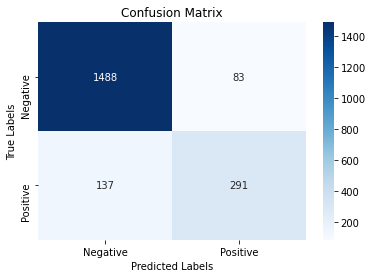

In [49]:
# Evaluation
result = evaluate(model, tokenizer, prefix=global_step)
print(result)
